In [1]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../data/')

In [2]:
data_dirname = '../data/'
label_filename = 'labels.dat'
prefix = 'ex'

ex_dirnames = os.listdir(data_dirname)
ex_dirnames = filter(lambda x: x.startswith(prefix), ex_dirnames)
ex_dirnames = sorted(ex_dirnames)
ex_dirnames = ex_dirnames

csv_filenames = ['pos', 'neg']
skip_prefixes = ['Charge', 'Blank', 'blank', 'Flav', 'flav', 'Compound', 'Comp']



for k_ex in range(len(ex_dirnames)):
    current_dirname = ex_dirnames[k_ex]
    with open(data_dirname+current_dirname+'/'+label_filename, 'r') as f:
        labels = f.readlines()
        labels = list(map(lambda x: int(x.replace('\n', '')), labels))
        labels = list(filter(lambda x: x != -1, labels))
    mz = []
    rt = []
    data = []
    samples = []
    for k_pol in range(len(csv_filenames)):
        current_filename = csv_filenames[k_pol]+'.csv'
        df = pd.read_csv(data_dirname+current_dirname+'/'+current_filename, skiprows=2)
        columns = df.columns.values
        columns = filter(lambda x: all([not x.startswith(y) for y in skip_prefixes]), columns)
        df = df[columns]
        mz.append(df.iloc[:, 0].values)
        rt.append(df.iloc[:, 1].values)
        data.append(df.values[:, 2:])
        samples.append(columns[2:])
        print(len(labels), df.values[:, 2:].shape)
    np.savez_compressed(
        data_dirname+current_dirname+'/'+current_dirname,
        mz=mz, rt=rt, samples=samples, data=data,
        csv_filenames=csv_filenames, labels=labels
    )   
    #del df

(78, (3132, 78))
(78, (4462, 78))
(36, (3049, 36))
(36, (3904, 36))
(216, (3129, 216))
(216, (3036, 216))
(216, (3859, 216))
(216, (2925, 216))
(105, (3917, 105))
(105, (1448, 105))
(104, (3507, 104))
(104, (2584, 104))
(115, (2927, 115))
(115, (2206, 115))


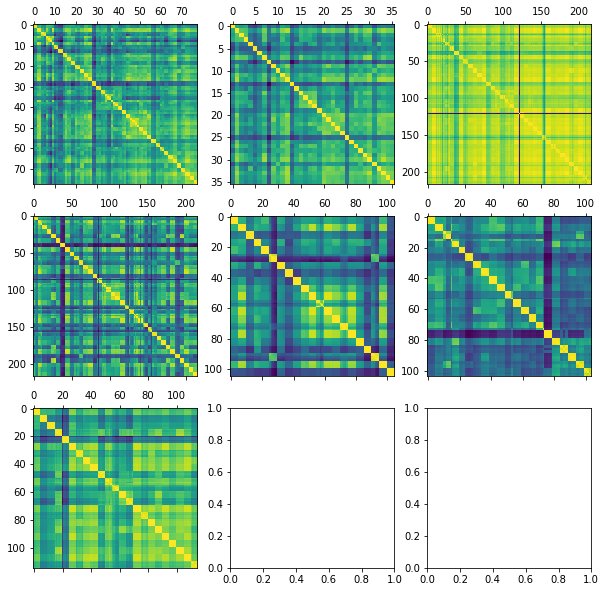

In [186]:
offsets = [0, 78, 36, 217, 216, 105, 104, 115]
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
title = ['ex1.1\n', 'ex1.1a\n', 'ex2\n', 'ex3\n', 'ex4\n', 'ex5\n', 'ex6\n']
for i in range(len(offsets)-1):
    offset = offsets[i+1]
    ind = int(np.sum(offsets[:i+1]))
 
    c = np.corrcoef(
        np.reshape(result[ind:ind+offset, :, :], [offset, -1])
    )
    j1, j2 = np.unravel_index([i], [3, 3])
    j1, j2 = int(j1), int(j2)
    ax[j1, j2].matshow(c)
    #ax[j1, j2].set_title(title[i])
    ax[j1, j2].set_aspect('auto')
plt.show()
    

In [4]:
mza = 100.
mzb = 900.
mz_step = 1.

pos_ind_in = 0
neg_ind_in = (pos_ind_in+1) % 2
pos_ind_out = 1
neg_ind_out = (pos_ind_out+1) % 2


result = []
labels = []
for k_ex in range(len(ex_dirnames)):
    current_dirname = ex_dirnames[k_ex]
    df = np.load(data_dirname+current_dirname+'/'+current_dirname+'.npz')
    mz = df['mz']
    rt = df['rt']
    data = df['data']
    labels += df['labels'].tolist()
    posNpoints, posNsamples = data[pos_ind_in].shape
    negNpoints, negNsamples = data[neg_ind_in].shape
    for k_sample in range(posNsamples):
        local_data = np.zeros([int((mzb - mza)//mz_step), 2])
        for k_point in range(max(posNpoints, negNpoints)):
            if k_point < posNpoints:
                mzind = np.trunc((mz[pos_ind_in][k_point] - mza)/mz_step)
                #mzind = np.round((mz[pos_ind_in][k_point] - mza)/mz_step)
                mzind = int(mzind)
                if (
                    (mza > mz[pos_ind_in][k_point]) or
                    (mzb <= mz[pos_ind_in][k_point]) or
                    (data[pos_ind_in][k_point, k_sample] == 0.) or
                    #(mzind >= int(np.round((mzb - mza)/mz_step))) or
                    (mzind >= int(np.trunc((mzb - mza)/mz_step))) or
                    (mzind < 0)
                ):
                    pass
                else:
                    local_data[mzind, pos_ind_out] = max(
                        local_data[mzind, pos_ind_out],
                        data[pos_ind_in][k_point, k_sample],
                        0
                    )
            if k_point < negNpoints:
                mzind = np.trunc((mz[neg_ind_in][k_point] - mza)/mz_step)
                #mzind = np.round((mz[neg_ind_in][k_point] - mza)/mz_step)
                mzind = int(mzind)
                if (
                    (mza > mz[neg_ind_in][k_point]) or
                    (mzb <= mz[neg_ind_in][k_point]) or
                    (data[neg_ind_in][k_point, k_sample] == 0.) or
                    #(mzind >= int(np.round((mzb - mza)/mz_step))) or
                    (mzind >= int(np.trunc((mzb - mza)/mz_step))) or
                    (mzind < 0)
                ):
                    pass
                else:
                    #print(mz[neg_ind_in][k_point], mz[neg_ind_in][k_point]-mza)
                    local_data[mzind, neg_ind_out] = max(
                        local_data[mzind, neg_ind_out],
                        data[neg_ind_in][k_point, k_sample],
                        0
                    )
        result.append(local_data)

result = np.array(result)

In [5]:
np.savez_compressed('../data/data.npz', data=result, labels=labels)

In [6]:
result.shape, len(labels)

((870, 800, 2), 870)

In [7]:
dirnames = os.listdir(data_dirname)
dirnames = list(filter(lambda x: x.startswith('ex'), dirnames))
dirnames = sorted(dirnames)

uninteresting_column_prefixes = [
    'Flav_all', 'Blank', 'blank', 'Compound', 'Comp', 'm/z', 'Charge', 'Retention time (min)'
]

ex_dict = {
    'experiment': [],
    'label': [],
    'name_pos': [],
    'name_neg': []
}

labels_filename = 'labels.dat'


for dirname in dirnames:
    with open(data_dirname+dirname+'/'+labels_filename, 'r') as f:
        tmp_labels = f.readlines()
        tmp_labels = list(map(lambda x: x.replace('\n', ''), tmp_labels))
        tmp_labels = list(filter(lambda x: (len(x) > 0), tmp_labels))
        tmp_labels = list(map(int, tmp_labels))
        tmp_labels = list(filter(lambda x: x != -1, tmp_labels))
    ex_dict['label'] += tmp_labels
    ex_dict['experiment'] += [dirname]*len(tmp_labels)
    for pol in ['pos', 'neg']:
        df = pd.read_csv(data_dirname+dirname+'/'+pol+'.csv', skiprows=2)
        data_columns = [x for x in df.columns if not x.startswith(tuple(uninteresting_column_prefixes))]
        data_columns = list(map(lambda x: x.replace('#', '_'), data_columns))
        if dirname == 'ex1':
            data_columns = list(map(lambda x: 'pr'+x, data_columns))
        ex_dict['name_'+pol] += data_columns
exdf = pd.DataFrame(ex_dict)


In [8]:
len(exdf), result.shape

(870, (870, 800, 2))

In [9]:
def correctorCSV(x):
    result, tail = x.split('_Seg', 1)
    if 'ul_AutoMSMS' in result:
        result = 'pr'+result
    if 'G26' in result:
        result = result.replace('G26', 'G25')
    if '10rc_1k10_3' in result:
        result = result.replace('10rc', '10c')
    if ('c_1k10_' in result) and (result.endswith('r')):
        result = result[:-1]
    result += '_Seg' + tail
    return result

def corrector(x):
    result, tail = x.split('_Seg', 1)
    if '0_u' in result:
        result = result.replace('0_u', '0u')
    if '5_u' in result:
        result = result.replace('5_u', '5u')
    if (result == 'C52-1_13'):
        result = result[:-2] + '3'
    if (result == '15+_1k5_10ul_12'):
        result = result[:-2] + '2'
    if (result == '33_1k10_10ul_') or (result == '33h_1k10_10ul_'):
        result += '6'
    result += '_Seg' + tail
    return result

exdf['name_neg'] = exdf['name_neg'].apply(corrector)
exdf['name_pos'] = exdf['name_pos'].apply(corrector)

exdf['name_neg'] = exdf['name_neg'].apply(correctorCSV)
exdf['name_pos'] = exdf['name_pos'].apply(correctorCSV)
exdf.head()

,experiment,label,name_neg,name_pos
0,ex1,1,pr1_1k10_20ul_1_Seg1Ev2,pr1_1k10_20ul_1_Seg1Ev1
1,ex1,1,pr1_1k10_20ul_2_Seg1Ev2,pr1_1k10_20ul_2_Seg1Ev1
2,ex1,2,pr2_1k10_10ul_1_Seg1Ev2,pr2_1k10_10ul_1_Seg1Ev1
3,ex1,2,pr2_1k10_10ul_2_Seg1Ev2,pr2_1k10_10ul_2_Seg1Ev1
4,ex1,3,pr3_1k10_10ul_1_Seg1Ev2,pr3_1k10_10ul_1_Seg1Ev1


In [10]:
df = pd.read_csv(data_dirname+'s_plant_species_ident.txt', sep='\t')
df['Sample Name'] = df['Sample Name'].apply(corrector)
df.head()

,Source Name,Factor Value[year],Unit,Term Source REF,Term Accession Number,Characteristics[Organism],Term Source REF.1,Term Accession Number.1,Characteristics[Organism part],Term Source REF.2,Term Accession Number.2,Protocol REF,Sample Name,Factor Value[location],Term Source REF.3,Term Accession Number.3
0,no_treatment,2016,year,CCONT,http://purl.obolibrary.org/obo/UO_0000036,Melilotus officinalis,NCBITAXON,NaN,leaf,BTO,NaN,Sample collection,10-1_1_Seg1Ev1,Altai Krai,NaN,NaN
1,no_treatment,2016,year,CCONT,http://purl.obolibrary.org/obo/UO_0000036,Melilotus officinalis,NCBITAXON,NaN,leaf,BTO,NaN,Sample collection,10-1_1_Seg1Ev2,Altai Krai,NaN,NaN
2,no_treatment,2016,year,CCONT,http://purl.obolibrary.org/obo/UO_0000036,Melilotus officinalis,NCBITAXON,NaN,leaf,BTO,NaN,Sample collection,10-1_2_Seg1Ev1,Altai Krai,NaN,NaN
3,no_treatment,2016,year,CCONT,http://purl.obolibrary.org/obo/UO_0000036,Melilotus officinalis,NCBITAXON,NaN,leaf,BTO,NaN,Sample collection,10-1_2_Seg1Ev2,Altai Krai,NaN,NaN
4,no_treatment,2016,year,CCONT,http://purl.obolibrary.org/obo/UO_0000036,Melilotus officinalis,NCBITAXON,NaN,leaf,BTO,NaN,Sample collection,10-1_3_Seg1Ev1,Altai Krai,NaN,NaN


In [11]:
treatment_pos = list(
    map(
        lambda x: dict(name_pos=x, treatment=df[df['Sample Name'] == x]['Source Name'].values[0]),
        exdf.name_pos
    )
)

treatment_neg = list(
    map(
        lambda x: dict(name_neg=x, treatment=df[df['Sample Name'] == x]['Source Name'].values[0]),
        exdf.name_neg
    )
)

In [12]:
tmp_dfpos = pd.DataFrame(treatment_pos)
tmp_dfneg = pd.DataFrame(treatment_neg)

assert np.all(tmp_dfpos.treatment.values == tmp_dfneg.treatment.values)
assert np.all(tmp_dfpos.name_pos.values == exdf.name_pos.values)

exdf['treatment'] = tmp_dfpos.treatment.values
exdf.head()

,experiment,label,name_neg,name_pos,treatment
0,ex1,1,pr1_1k10_20ul_1_Seg1Ev2,pr1_1k10_20ul_1_Seg1Ev1,no_treatment
1,ex1,1,pr1_1k10_20ul_2_Seg1Ev2,pr1_1k10_20ul_2_Seg1Ev1,no_treatment
2,ex1,2,pr2_1k10_10ul_1_Seg1Ev2,pr2_1k10_10ul_1_Seg1Ev1,no_treatment
3,ex1,2,pr2_1k10_10ul_2_Seg1Ev2,pr2_1k10_10ul_2_Seg1Ev1,no_treatment
4,ex1,3,pr3_1k10_10ul_1_Seg1Ev2,pr3_1k10_10ul_1_Seg1Ev1,no_treatment


In [13]:
def corrector2(x):
    if x in [
        'pr1_1k10_20ul_AutoMSMS_Pos__1_Seg1Ev1',
        'pr16_1k10_20ul_AutoMSMS_Pos__1_Seg1Ev1',
        'pr18_1k10_20ul_AutoMSMS_Pos__1_Seg1Ev1',
        'pr19_1k10_20ul_AutoMSMS_Pos__1_Seg1Ev1',
        'pr35_1k10_20ul_AutoMSMS_Pos__1_Seg1Ev1',
        'pr20_1k10_20ul_AutoMSMS_Pos__1_Seg1Ev1'
    ]:
        return x.replace('_20ul_', '_10ul_')
    return x

exdf['name_pos'] = exdf['name_pos'].apply(corrector2)

In [14]:
def trimmer(x):
    result = x.split('_Seg')[0]
    if 'AutoMSMS' in x:
        result = x.split('_AutoMSMS')[0]
        result += '_AutoMSMS'
    if '0_u' in result:
        result = result.replace('0_u', '0u')
    if '5_u' in result:
        result = result.replace('5_u', '5u')
    if (result == 'C52-1_13'):
        result = result[:-2] + '3'
    if (result == '15+_1k5_10ul_12'):
        result = result[:-2] + '2'
    if (result == '33_1k10_10ul_') or (result == '33h_1k10_10ul_'):
        result += '6'
    return result

exdf['sample_pos'] = exdf['name_pos'].apply(trimmer)
exdf['trial_pos'] = exdf['sample_pos'].apply(lambda x: x[::-1].split('_', 1)[0][::-1])
exdf['sample_pos'] = exdf['sample_pos'].apply(lambda x: x[::-1].split('_', 1)[1][::-1])

exdf['sample_neg'] = exdf['name_neg'].apply(trimmer)
exdf['trial_neg'] = exdf['sample_neg'].apply(lambda x: x[::-1].split('_', 1)[0][::-1])
exdf['sample_neg'] = exdf['sample_neg'].apply(lambda x: x[::-1].split('_', 1)[1][::-1])

In [15]:
tmp = np.char.array(exdf['sample_neg'].values)
tmp = tmp + '_'
tmp = tmp + np.char.array(exdf['treatment'].values)
exdf['sample'] = tmp
print(len(np.unique(tmp)), len(exdf))
exdf.head()

#593 no_treatment

(187, 870)


,experiment,label,name_neg,name_pos,treatment,sample_pos,trial_pos,sample_neg,trial_neg,sample
0,ex1,1,pr1_1k10_20ul_1_Seg1Ev2,pr1_1k10_20ul_1_Seg1Ev1,no_treatment,pr1_1k10_20ul,1,pr1_1k10_20ul,1,pr1_1k10_20ul_no_treatment
1,ex1,1,pr1_1k10_20ul_2_Seg1Ev2,pr1_1k10_20ul_2_Seg1Ev1,no_treatment,pr1_1k10_20ul,2,pr1_1k10_20ul,2,pr1_1k10_20ul_no_treatment
2,ex1,2,pr2_1k10_10ul_1_Seg1Ev2,pr2_1k10_10ul_1_Seg1Ev1,no_treatment,pr2_1k10_10ul,1,pr2_1k10_10ul,1,pr2_1k10_10ul_no_treatment
3,ex1,2,pr2_1k10_10ul_2_Seg1Ev2,pr2_1k10_10ul_2_Seg1Ev1,no_treatment,pr2_1k10_10ul,2,pr2_1k10_10ul,2,pr2_1k10_10ul_no_treatment
4,ex1,3,pr3_1k10_10ul_1_Seg1Ev2,pr3_1k10_10ul_1_Seg1Ev1,no_treatment,pr3_1k10_10ul,1,pr3_1k10_10ul,1,pr3_1k10_10ul_no_treatment


In [16]:
labels_dict = {}
labels_unique = list(set(exdf.label.values))
exdf['label'] = exdf['label'].astype('i')
k = 0
for i in range(len(labels_unique)):
    label = labels_unique[i]
    tmp = exdf[exdf['label']==label]
    samples_unique = np.unique(tmp['sample'].values)
    cur_dict = {}
    for j in range(len(samples_unique)):
        ind = tmp[tmp['sample'] == samples_unique[j]].index.values
        cur_dict[samples_unique[j]] = ind
    labels_dict[label] = cur_dict


In [17]:
phys_labels = []
for i in range(len(labels_unique)):
    key = labels_unique[i]
    phys_labels += [key]*len(labels_dict[key])
print(len(phys_labels))

187


In [18]:
uni, cnt = np.unique(phys_labels, return_counts=True)
np.mean(cnt), np.std(cnt, ddof=1)

(5.194444444444445, 0.7099072150416942)

In [19]:
data_filename = 'data.npz'

labels_init = np.load(data_dirname+data_filename)['labels']
labels_actual_unique = np.unique(labels_init)
def labelMapper(x):
    if x in labels_actual_unique:
        return x
    return -1

exdf['label_actual'] = exdf['label'].map(labelMapper)
labels_actual_dict = {}
for i in range(len(labels_actual_unique)):
    label = labels_actual_unique[i]
    tmp = exdf[exdf['label_actual']==label]
    samples_unique = np.unique(tmp['sample'].values)
    cur_dict = {}
    for j in range(len(samples_unique)):
        ind = tmp[tmp['sample'] == samples_unique[j]].index.values
        cur_dict[samples_unique[j]] = ind
    labels_actual_dict[label] = cur_dict


In [21]:
phys_labels_actual = []
sample_names = []
for i in range(len(labels_actual_unique)):
    key = labels_actual_unique[i]
    phys_labels_actual += [key]*len(labels_actual_dict[key])
    sample_names.append(labels_actual_dict[key].keys())
print(len(phys_labels_actual))

187


In [24]:
uni_actual, cnt_actual = np.unique(phys_labels_actual, return_counts=True)
np.mean(cnt_actual), np.std(cnt_actual, ddof=1)

(5.194444444444445, 0.7099072150416942)

In [25]:
np.savez_compressed(
    data_dirname+'physical', phys_labels_actual=phys_labels_actual, labels_actual_dict=labels_actual_dict,
    sample_names=sample_names
)

In [26]:
snm = reduce(lambda x, y: x+y, sample_names)

In [213]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits = 100
random_state = 732
filename = 'physical_cv_indices_nc'
dirname = '../'

filename732 = 'phys_cv_indices_732'

y = phys_labels_actual
X = np.empty([len(y), 0])

splitter732 = StratifiedShuffleSplit(
    n_splits=n_splits,
    test_size=0.3,
    train_size=0.7,
    random_state=random_state
)

train_indices_732 = []
test_indices_732 = []

np.random.seed(random_state)
for train_index, test_index in splitter732.split(X, y):
    phys_train_index = []
    phys_test_index = []
    for i in range(max(len(train_index), len(test_index))):
        if i < len(train_index):
            train_ind = train_index[i]
            train_key = snm[train_ind]
            i_train = y[train_ind]
            phys_train_index += labels_actual_dict[i_train][train_key].tolist()
        if i < len(test_index):
            test_ind = test_index[i]
            test_key = snm[test_ind]
            i_test = y[test_ind]
            phys_test_index.append(
                np.random.choice(
                    labels_actual_dict[i_test][test_key]
                )
            )
    train_indices_732.append(phys_train_index)
    test_indices_732.append(phys_test_index)
    np.savez_compressed(
        data_dirname+filename732, n_splits=n_splits, random_state=random_state,
        train_indices=train_indices_732, test_indices=test_indices_732
    )

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit

n_splits=100
random_state=235
filename='physical_cv_indices_nc'
dirname = '../'

filename73 = '2phys_cv_indices_73'

y = phys_labels_actual
X = np.empty([len(y), 0])



splitter73 = StratifiedShuffleSplit(
    n_splits=n_splits,
    test_size=0.3,
    train_size=0.7,
    random_state=random_state
)

train_indices_73 = []
test_indices_73 = []
np.random.seed(random_state)

tmp1, tmp2 = [], []

for train_index, test_index in splitter73.split(X, y):
    phys_train_index = []
    phys_test_index = []
    for i in range(max(len(train_index), len(test_index))):
        if i < len(train_index):
            train_ind = train_index[i]
            train_key = snm[train_ind]
            i_train = y[train_ind]
            phys_train_index += labels_actual_dict[i_train][train_key].tolist()
            tmp1.append(train_key)
        if i < len(test_index):
            test_ind = test_index[i]
            test_key = snm[test_ind]
            i_test = y[test_ind]
            phys_test_index.append(
                np.random.choice(
                    labels_actual_dict[i_test][test_key]
                )
            )
            tmp2.append(test_key)
    train_indices_73.append(phys_train_index)
    test_indices_73.append(phys_test_index)
    np.savez_compressed(
        data_dirname+filename73, n_splits=n_splits, random_state=random_state,
        train_indices=train_indices_73, test_indices=test_indices_73
    )

In [215]:
len(tmp1), len(tmp2)

(13000, 5700)

In [216]:
exdf[exdf['sample'] == '2c_1k10_no_treatment']

,experiment,label,name_neg,name_pos,treatment,sample_pos,trial_pos,sample_neg,trial_neg,sample,label_actual
656,ex5,34,2c_1k10_1_Seg1Ev2,2c_1k10_1_Seg1Ev1,no_treatment,2c_1k10,1,2c_1k10,1,2c_1k10_no_treatment,34
657,ex5,34,2c_1k10_2_Seg1Ev2,2c_1k10_2_Seg1Ev1,no_treatment,2c_1k10,2,2c_1k10,2,2c_1k10_no_treatment,34
658,ex5,34,2c_1k10_3_Seg1Ev2,2c_1k10_3_Seg1Ev1,no_treatment,2c_1k10,3,2c_1k10,3,2c_1k10_no_treatment,34
659,ex5,34,2c_1k10_4_Seg1Ev2,2c_1k10_4_Seg1Ev1,no_treatment,2c_1k10,4,2c_1k10,4,2c_1k10_no_treatment,34
660,ex5,34,2c_1k10_5_Seg1Ev2,2c_1k10_5_Seg1Ev1,no_treatment,2c_1k10,5,2c_1k10,5,2c_1k10_no_treatment,34


['pr1_1k10_10ul_no_treatment']


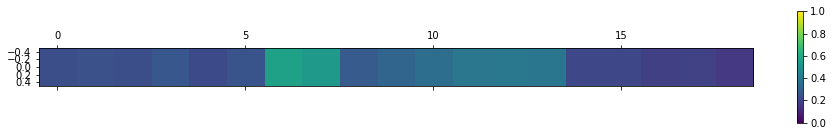

['17c_1k10_no_treatment' '2_1k10_10ul_no_treatment']


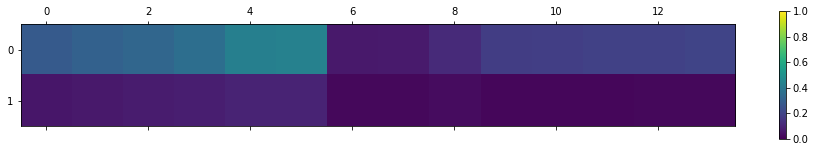

['3h_1k10_10ul_120h_heat_60C']


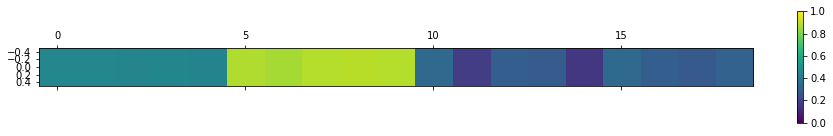

['pr4_1k50_5ul_no_treatment' '4r_5month_storing_room_temp']


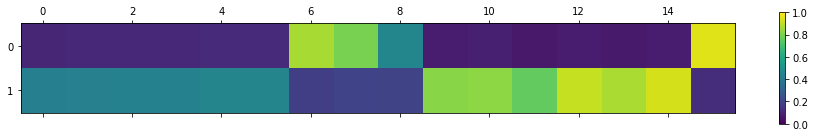

['4+_1k5_10ul_no_treatment' '5r_5month_storing_room_temp']


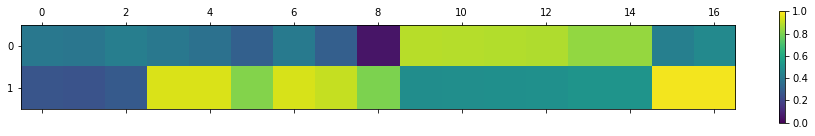

['pr6_1k10_10ul_no_treatment' '1c_1k10_no_treatment']


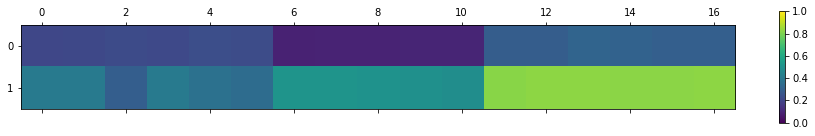

['16c_1k10_no_treatment']


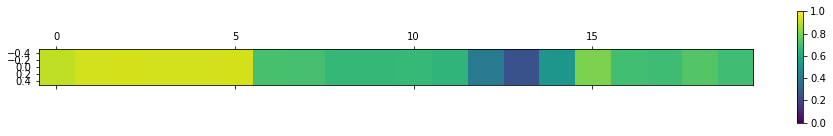

['20+_1k5_10ul_no_treatment' '8r_5month_storing_room_temp']


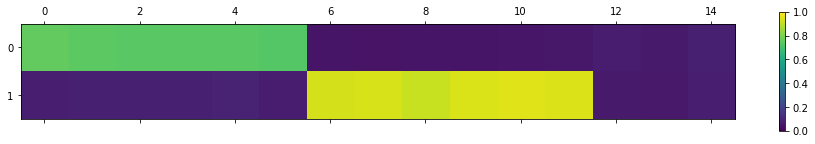

['9h_1k10_10ul_120h_heat_60C']


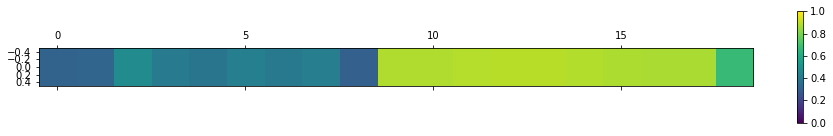

['10r_5month_storing_room_temp']


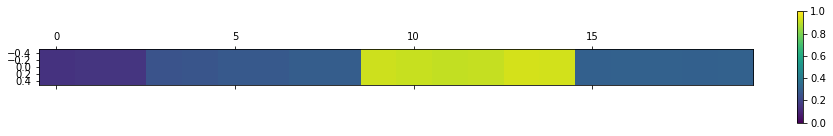

['11r_5month_storing_room_temp' '11h_1k10_10ul_120h_heat_60C']


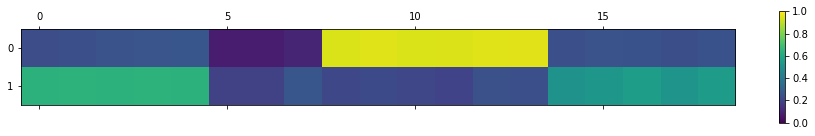

['pr12_1k10_10ul_no_treatment']


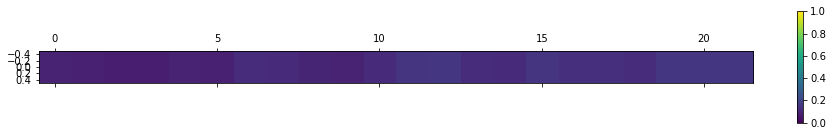

['2+_1k5_10ul_no_treatment']


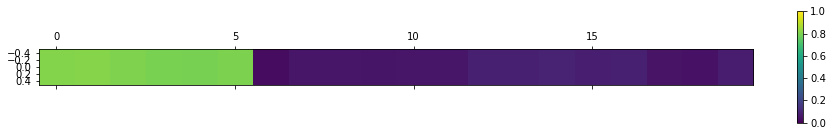

['6c_1k10_no_treatment']


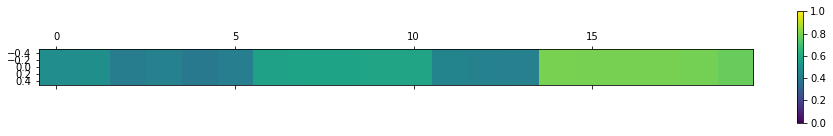

['15r_5month_storing_room_temp']


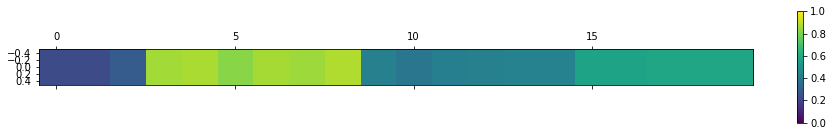

['16_no_treatment' 'pr16_1k10_10ul_no_treatment']


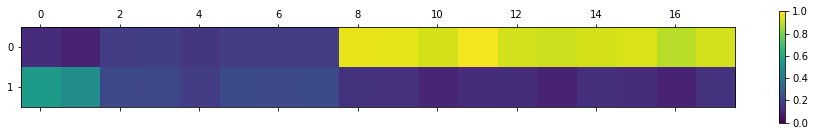

['pr17_1k50_10ul_no_treatment' 'pr17_1k10_10ul_no_treatment']


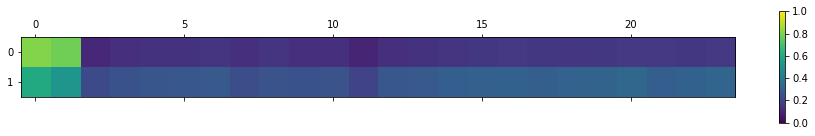

['1+_1k5_10ul_no_treatment' '18r_5month_storing_room_temp']


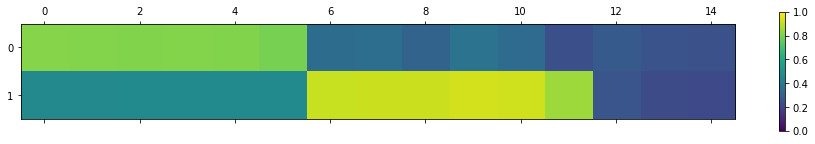

['19h_1k10_20ul_120h_heat_60C' '19r_5month_storing_room_temp']


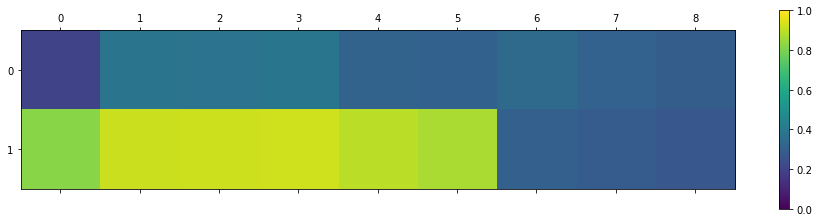

['20_1k10_10ul_no_treatment']


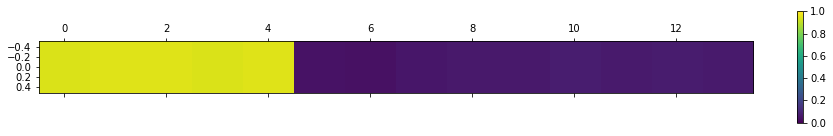

['pr21_1k10_10ul_no_treatment']


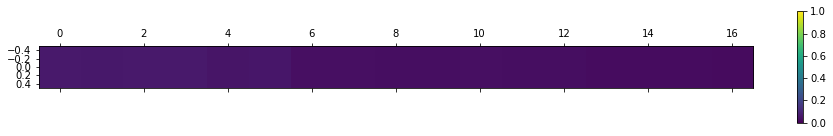

['pr22_1k10_5ul_no_treatment' '22r_5month_storing_room_temp']


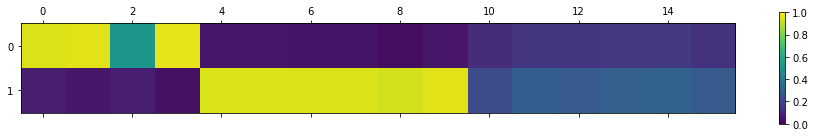

['23r_5month_storing_room_temp']


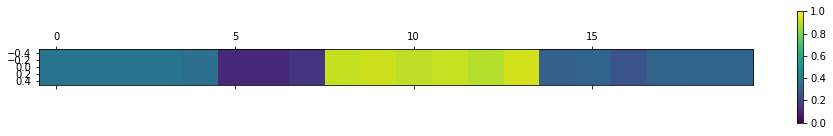

['24_1k10_10ul_no_treatment' '15c_1k10_no_treatment']


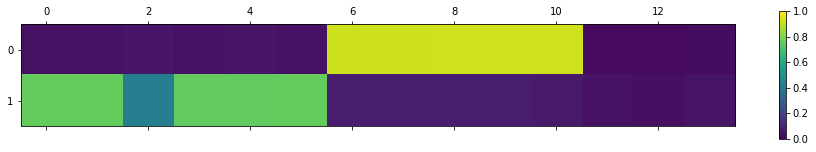

['25r_5month_storing_room_temp' '25h_1k10_10ul_120h_heat_60C']


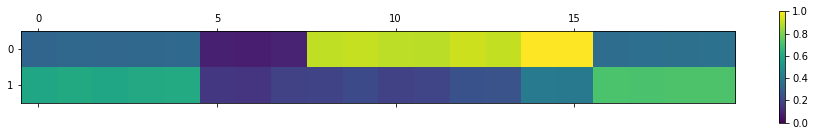

['pr26_1k10_10ul_no_treatment' '15+_1k5_10ul_no_treatment']


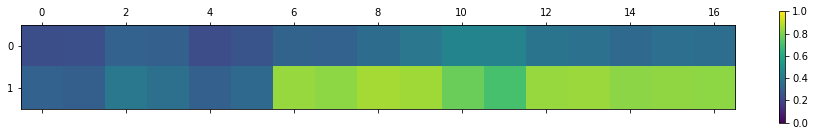

['4c_1k10_no_treatment' 'pr27_1k10_10ul_no_treatment']


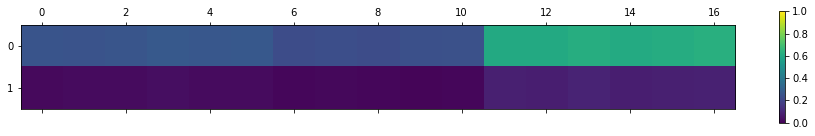

['5+_1k5_10ul_no_treatment']


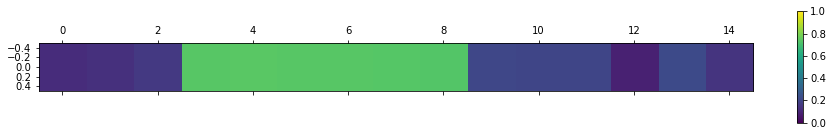

['29_1k10_10ul_no_treatment']


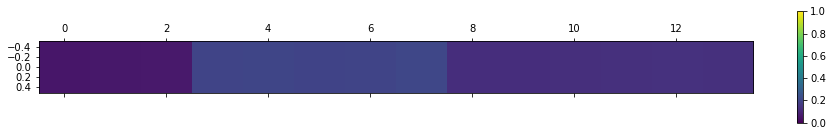

['30h_1k10_10ul_120h_heat_60C' '12c_1k10_no_treatment']


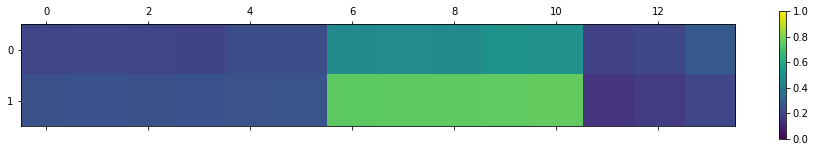

['pr31_1k10_10ul_no_treatment' '14+_1k5_10ul_no_treatment']


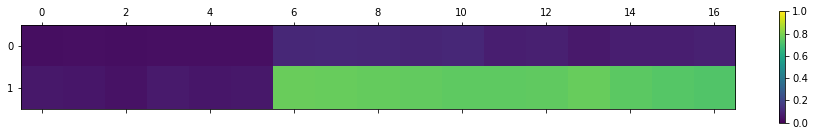

['32_1k10_10ul_no_treatment']


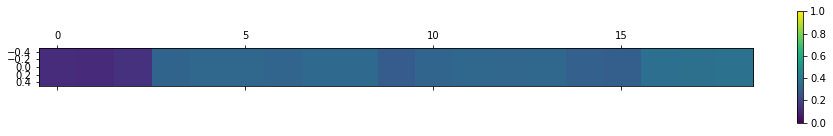

['19c_1k10_no_treatment' 'pr33_1k10_10ul_no_treatment']


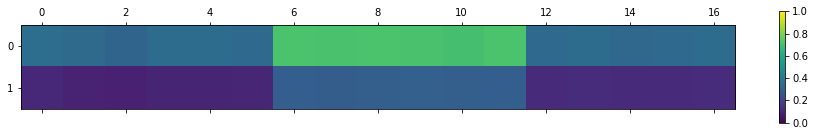

['34h_1k10_10ul_120h_heat_60C' '2c_1k10_no_treatment']


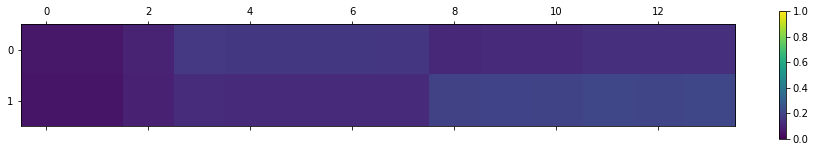

['35_1k10_20ul_no_treatment' 'pr35_1k10_20ul_no_treatment']


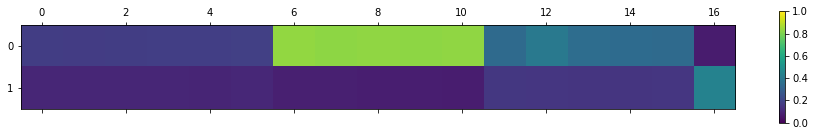

['16+_1k5_10ul_no_treatment' 'pr36_1k10_10ul_no_treatment']


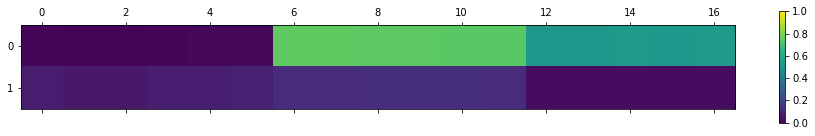

In [218]:
import matplotlib.pyplot as plt
%matplotlib inline

for k in range(len(train_indices_73)):
    for i in range(len(uni_actual)):
        l = uni_actual[i]
        ind1 = np.where(np.array(labels)[train_indices_73[k]] == l)[0]
        ind2 = np.where(np.array(labels)[test_indices_73[k]] == l)[0]
        
        print(np.array(tmp2)[ind2])
        c = np.corrcoef(
            np.reshape(result[train_indices_73[k]][ind1], [len(ind1), -1]),
            np.reshape(result[test_indices_73[k]][ind2], [len(ind2), -1]),
            rowvar=True
        )
        c = c[
            :len(ind1),
            len(ind1):
        ].T
        
        plt.matshow(c, vmin=0., vmax=1.)
        plt.colorbar()
        plt.show()
    break